**Implementacija jednostavnog chatbota koristeći MLP NN**

Ovaj notebook predstavlja osnovni set koraka za implementaciju jednostavnog chatbota na bazi dubokog i/ili mašinskog učenja koristeći Multi-level perceprton neuronsku mrežu (Sequential model).

Osnovni importi

In [ ]:
%pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import json
import string
import random
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer 
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Učitavanje podataka

In [2]:
from google.colab import drive
drive.mount('/content/drive')

f = open('/content/drive/My Drive/BasicNNChatbot/intents.json',)

data = json.load(f)

Mounted at /content/drive


Pretprocesiranje podataka

In [3]:
# Inicijalizacija lemmatizatora da bismo dobili korijen svake riječi 
# (stem)

lemmatizer = WordNetLemmatizer()

words = []
classes = []
doc_X = []
doc_y = []

# Liste za sve kategorije podataka
# Tokenizacija svakog obrasca/patterna i dodavanje u pojedine liste
for intent in data["intents"]:
  for pattern in intent["patterns"]:
      tokens = nltk.word_tokenize(pattern)
      words.extend(tokens)
      doc_X.append(pattern)
      doc_y.append(intent["tag"])

  # Dodavanje taga u listu klasa, ukoliko vec ne postoji 
  if intent["tag"] not in classes:
      classes.append(intent["tag"])


# Lematizacija i pretvaranje svih riječi iz rječnika u mala slova
# ako ne pripadaju punktuacijskim riječima
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]

# Sortiranje rječnika i klasa i pretvaranje u skup radi eliminacije
# duplikata
words = sorted(set(words))
classes = sorted(set(classes))

Ispis rezultata pretprocesiranja

In [4]:
print(words)
print('------------------------------------------------------------------------------------')
print(classes)
print('------------------------------------------------------------------------------------')
print(doc_X)
print('------------------------------------------------------------------------------------')
print(doc_y)
print('------------------------------------------------------------------------------------')

["'s", 'adios', 'are', 'birthday', 'born', 'bye', 'called', 'cya', 'do', 'doing', 'for', 'g2g', 'going', 'hang', 'hello', 'hi', 'how', 'is', 'it', 'name', 'old', 'out', 'plan', 'see', 'some', 'there', 'this', 'time', 'to', 'up', 'want', 'week', 'weekend', 'were', 'what', 'whats', 'when', 'who', 'ya', 'you', 'your']
------------------------------------------------------------------------------------
['age', 'date', 'goodbye', 'greeting', 'name']
------------------------------------------------------------------------------------
['Hello', 'How are you?', 'Hi there', 'Hi', 'Whats up', "How's it going?", 'How old are you?', 'When is your birthday?', 'When were you born?', 'what are you doing this weekend?', 'do you want to hang out some time?', 'what are your plans for this week', "what's your name?", 'what are you called?', 'who are you?', 'bye', 'g2g', 'see ya', 'adios', 'cya']
------------------------------------------------------------------------------------
['greeting', 'greeting', 

Priprema trening podataka

In [5]:
# Lista podataka za treniranje
training = []
out_empty = [0] * len(classes)

# Kreiranje BoW modela
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)    
    
    # Oznacavanje indeksa klase kojoj pripada trenutni obrazac
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1    
    
    # Dodavanje hot encoded BoW i pratecih klasa u trening podatke
    training.append([bow, output_row])
    
# Shuffle podataka i pretvaranjenu niz
random.shuffle(training)
training = np.array(training, dtype=object)


# Splitanje karakteristika i ciljanih labela
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

Model

In [6]:
# Definisanje parametara modela
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
epochs = 200

# MLP model
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(output_shape, activation = "softmax"))
adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=["accuracy"])
print(model.summary())
history = model.fit(x=train_X, y=train_y, epochs=200, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5376      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,957
Trainable params: 13,957
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
1/1 [==============================

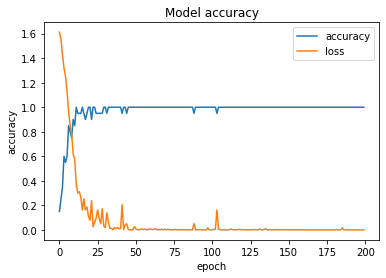

In [7]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.show()

Nakon formiranja modela za chatbot, prelazimo na kreiranje pomoćnih funkcija za osnovnu implementaciju chatbota:

In [8]:
def clean_text(text): 
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

def bag_of_words(text, vocab): 
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens: 
    for idx, word in enumerate(vocab):
      if word == w: 
        bow[idx] = 1
  return np.array(bow)

def pred_class(text, vocab, labels): 
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0]
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]

  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

def get_response(intents_list, intents_json): 
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents: 
    if i["tag"] == tag:
      result = random.choice(i["responses"])
      break
  return result

Za pokretanje chatbota, koristit ćemo beskonačnu petlju:

In [12]:
# running the chatbot
while True:
    print("YOU: ")
    message = input("")
    if message == "end": 
      break
    intents = pred_class(message, words, classes)
    result = get_response(intents, data)
    print("LAKI: ")
    print(result)

YOU: 
hello
LAKI: 
Hi!
YOU: 
how are you
LAKI: 
How do you do?
YOU: 
what is your age
LAKI: 
I am available all week
YOU: 
how old r u
LAKI: 
24.6.1998.
YOU: 
plans for the weekend?
LAKI: 
I don't have any plans
YOU: 
ok, bye laki
LAKI: 
Speak soon!
YOU: 
end
